<a href="https://colab.research.google.com/github/Vivek084c/From_Scratch/blob/main/siglip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -L http://i.imgur.com/8o9DXSj.jpeg --output image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 44094  100 44094    0     0  33388      0  0:00:01  0:00:01 --:--:-- 54103


In [2]:

!nvidia-smi

Sun Mar  2 15:48:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

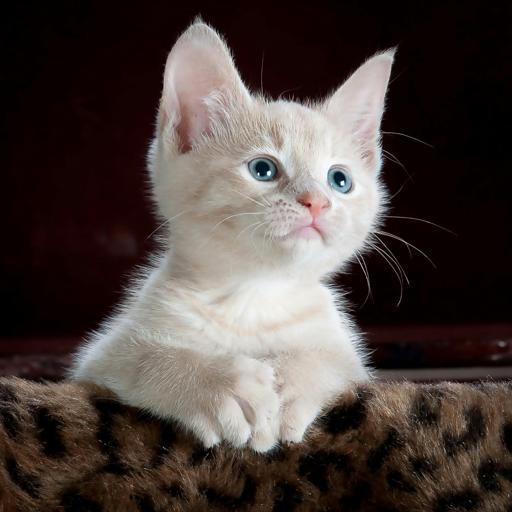

In [3]:
from PIL import Image

img = Image.open("image.jpg")
img

In [4]:
# importing the libraries
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig


In [5]:
# we are using 224 by 224 images
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
#getting the complete model along with weights
vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=False))

vision_model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

## preprocessing the image so that the model can process it

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass


from torchvision import transforms

def preprocess_image(image, image_size=224):
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    image_tensor = preprocess(image)
    #(3, 224, 224) --> unsqueeze --> (1, 3, 224, 224)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

image_tensor = preprocess_image(img)

#config used by the model
embed_dim = 768 #defining the embedding
patch_size = 16  # each piece of the image is 16*16 pixel
image_size = 224
num_of_pathches = (image_size // patch_size) **2 # no of individual piece of the image

#we dont have gradient here
with torch.no_grad():
  patch_embeddings = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size = patch_size, stride = patch_size)
  patches = patch_embeddings(image_tensor)

patches.shape, num_of_pathches



(torch.Size([1, 768, 14, 14]), 196)

In [7]:
# geenrating the postion embedding
position_embedding = nn.Embedding(num_of_pathches, embed_dim)
print("postion embeddings : \n")
print(position_embedding)

position_ids = torch.arange(num_of_pathches).expand((1, -1))
print("position_ids : \n")
print(position_ids)

print("position_ids shape : \n")
position_ids.shape

postion embeddings : 

Embedding(196, 768)
position_ids : 

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 16

torch.Size([1, 196])

In [8]:
position_embedding

Embedding(196, 768)

#adding the path embedding with the position embedding


In [9]:
# after flatten (1, 768, 196)
embeddings = patches.flatten(start_dim=2, end_dim=-1)
# (1, 768, 196) -> (1, 196, 768)
embeddings = embeddings.transpose(1,2)

embeddings = embeddings + position_embedding(position_ids)

embeddings.shape

torch.Size([1, 196, 768])

## visualising the embeddings

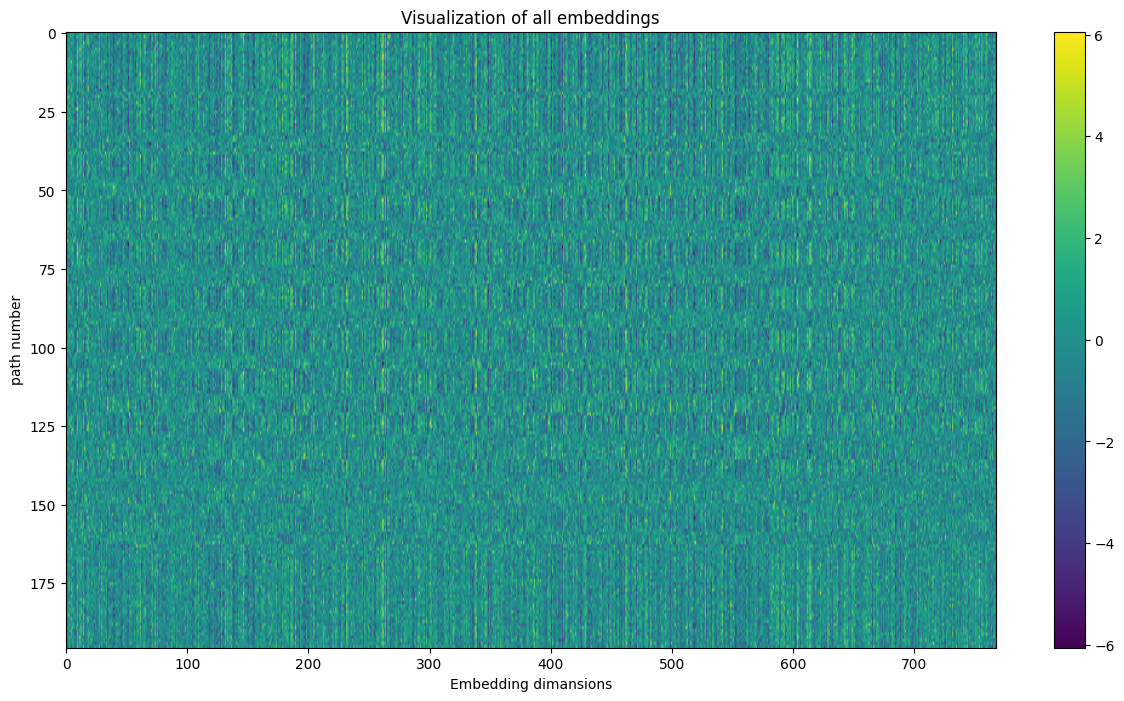

In [10]:
import matplotlib.pyplot as plt

patch_vis = embeddings[0].detach().numpy() # shape: [196, 768]

plt.figure(figsize=(15, 8))
plt.imshow(patch_vis, aspect = "auto", cmap="viridis")
plt.colorbar()

plt.title("Visualization of all embeddings")
plt.xlabel("Embedding dimansions")
plt.ylabel("path number")
plt.show()


# comparing to the trained embeddings

torch.Size([1, 196, 768])


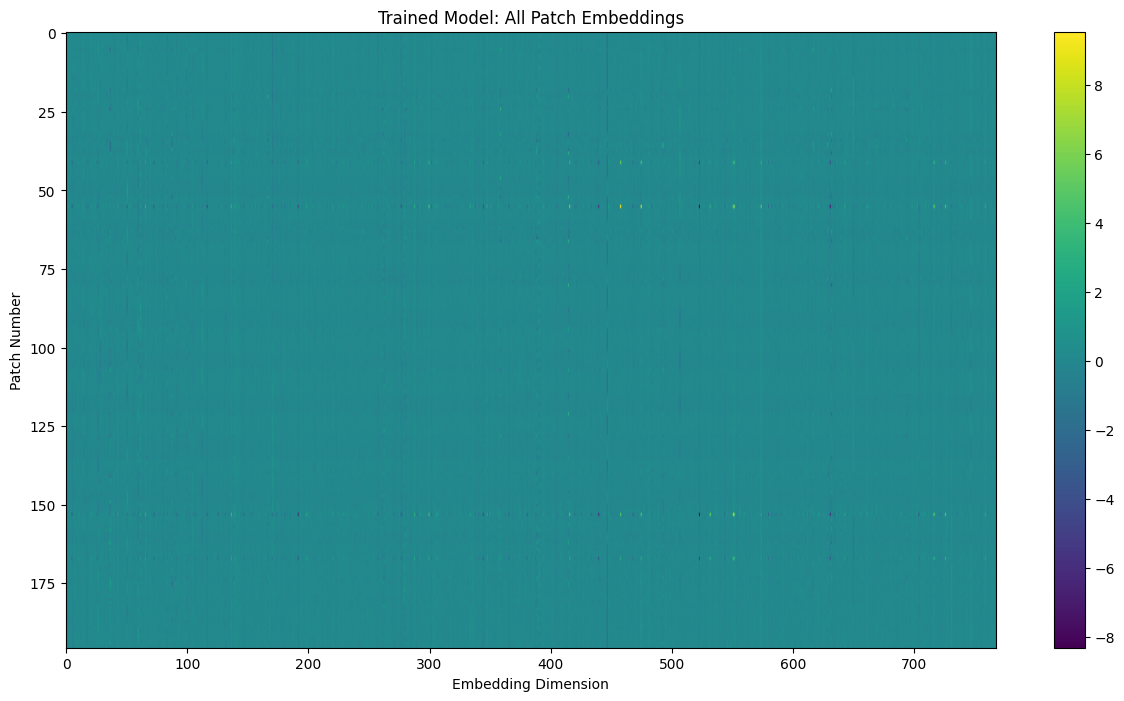

In [11]:
vision_model.eval()
inputs = processor(images=img, return_tensors="pt")

with torch.no_grad():
    patch_embeddings = vision_model.vision_model.embeddings(inputs.pixel_values)

print(patch_embeddings.shape)

patches_viz = patch_embeddings[0].detach().numpy()  # Shape: [196, 768]

plt.figure(figsize=(15, 8))
plt.imshow(patches_viz, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Trained Model: All Patch Embeddings')
plt.xlabel('Embedding Dimension')
plt.ylabel('Patch Number')
plt.show()

In [12]:
#defing the schema for the embedding
@dataclass
class SiglipVisionConfig:
  num_channels: int = 3
  embed_dim: int = 768
  image_size: int = 224
  patch_size: int = 16

class SiglipVisionEmbeddings(nn.Module):
  def __init__(self, config: SiglipVisionConfig):
    super().__init__()
    self.config = config

    self.num_channels = config.num_channels
    self.embed_dim = config.embed_dim
    self.image_size = config.image_size
    self.patch_size = config.patch_size

    #geenrating the path embeddings
    self.patch_embedding = nn.Conv2d(
      in_channels=self.num_channels,
      out_channels=self.embed_dim,
      kernel_size=self.patch_size,
      stride=self.patch_size,
      padding="valid",
    )

    self.num_patches = (self.image_size // self.patch_size) ** 2
    self.num_positions = self.num_patches
    self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
    self.register_buffer(
      "position_ids",
      torch.arange(self.num_positions).expand((1, -1)),
      persistent=False,
    )

  def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
    B, C, H, W = pixel_values.shape
    #geenrating the embeding by combiing postion embedding and position embedding
    patch_embeds = self.patch_embedding(pixel_values)
    embeddings = patch_embeds.flatten(start_dim=2, end_dim=-1)
    embeddings = embeddings.transpose(1, 2)
    embeddings = embeddings + self.position_embedding(self.position_ids)
    return embeddings

In [13]:
#generating the embeddings using the image tensor generated after preporcessing the img
embd = SiglipVisionEmbeddings(SiglipVisionConfig())
embd(image_tensor).shape

torch.Size([1, 196, 768])

In [14]:
#getting the weights and bias
embd.state_dict()

OrderedDict([('patch_embedding.weight',
              tensor([[[[-4.8220e-03,  1.4500e-02,  3.1231e-02,  ...,  9.4801e-03,
                         -2.0313e-02, -3.4109e-03],
                        [-1.2026e-02, -1.6870e-02, -1.8742e-02,  ...,  1.5099e-02,
                          1.3383e-02, -2.9352e-02],
                        [-1.4008e-03,  3.0956e-02,  3.4091e-02,  ...,  2.6414e-02,
                         -1.5823e-02, -1.6320e-02],
                        ...,
                        [-8.6404e-03, -2.3169e-02, -9.2740e-03,  ...,  3.0640e-02,
                          2.2829e-03,  1.0633e-02],
                        [ 1.8020e-02,  8.4577e-04, -6.7812e-03,  ...,  1.6712e-02,
                         -3.1396e-02,  1.1690e-02],
                        [ 4.9386e-03, -1.0487e-02, -1.4566e-02,  ...,  1.4177e-02,
                          8.5947e-03,  1.2120e-02]],
              
                       [[-2.7213e-02,  4.8480e-03, -3.1926e-03,  ...,  2.7055e-02,
                      

# verifying if the implemnetation of the embedding class is correct by comparing with hugginga face embedding

In [15]:
from transformers import SiglipVisionModel as HFSiglipVisionModel

#getting the weights and bias from our model
our_state_dict = embd.state_dict()
#getting the weights and bias from the hugging face model
hf_state_dict = {k.replace("vision_model.embeddings.", ""): v for k, v in vision_model.state_dict().items() if "vision_model.embeddings." in k}

#combing the dict with each other
our_state_dict.update(hf_state_dict)
embd.load_state_dict(our_state_dict)

with torch.no_grad():
    #generating the output from out model
    our_output = embd(image_tensor)
    #geenrating the output from the hugging face model
    hf_output = vision_model.vision_model.embeddings(image_tensor)

    #computing the output and checking if the implementataion is correct
    print("Max difference between our output and HF output:", torch.max(torch.abs(our_output - hf_output))) # =0, so they match!

Max difference between our output and HF output: tensor(0.)


# Implenmenting the encoder layer

In [16]:
import math

class Head(nn.Module):
    """ A single head of the multi-head attention """

    def __init__(self, n_in, n_head, context_length):
        super().__init__()
        #defining the no of head
        self.head_size = n_head

        #generating the linear vecotor of key, query, value
        self.key = nn.Linear(n_in, n_head, bias=False)
        self.query = nn.Linear(n_in, n_head, bias=False)
        self.value = nn.Linear(n_in, n_head, bias=False)

    def forward(self, x):
        #getting the batch size, token and hidden dimensions
        B, T, C = x.shape

        #generating 3 seperate vector from the 196 patches
        k = self.key(x) #contatins the imformation that the patch contains
        q = self.query(x) #this vectore tell what information this vector is looking for
        v = self.value(x) #this vector is the vector that gets aggrigated if there is a match

        #performing attention score calculation
        wei = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size)) # we perform scaling to prevent ovetshoot in values
        wei = F.softmax(wei, dim=-1) #getting the probability distirbution of each batch
        out = wei @ v #generating the output by incorporating the attention vector -> allows information to flow in between the tokens
        return out

#implenmenting the multi head attention to run in parallel
class MultiHeadAttention(nn.Module):
    """ Multi-head attention implementation with concatenating every head's output"""

    def __init__(self, num_head, n_in, head_size, context_length):
        super().__init__()
        self.head_size = head_size
        self.num_head = num_head
        self.heads = [Head(n_in, head_size, context_length) for _ in range(num_head)]
        self.proj = nn.Linear(n_in, n_in)


    def forward(self, x):
        out = [h(x) for h in self.heads]
        out = torch.concat(out, -1)
        out = self.proj(out)
        return out




### processing all the attention head in parallel

In [17]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0

class SiglipAttention(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, hidden_states):
        # the hidden states are the embeddings of the patches, so (batch_size, num_patches, embed_dim)
        B, T, C = hidden_states.shape
        q_states = self.q_proj(hidden_states)
        k_states = self.k_proj(hidden_states)
        v_states = self.v_proj(hidden_states)

        q_states = q_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        k_states = k_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        v_states = v_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)

        attn_weights = (q_states @ k_states.transpose(-2, -1)) * (1.0 / math.sqrt(k_states.size(-1)))
        attn_weights = F.softmax(attn_weights, dim=-1).to(q_states.dtype)
        attn_weights = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_outs = attn_weights @ v_states
        attn_outs = attn_outs.transpose(1, 2)
        attn_outs = attn_outs.reshape(B, T, C).contiguous()
        attn_outs = self.out_proj(attn_outs)
        return attn_outs

batch_size = 1
num_patches = 196
embed_dim = 768

hidden_states = torch.randn(batch_size, num_patches, embed_dim)
config = SiglipVisionConfig(
    attention_dropout=0.0,
    num_attention_heads=12,
    hidden_size=768
)
attention = SiglipAttention(config)
output = attention(hidden_states)

print(f"Input shape: {hidden_states.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 196, 768])
Output shape: torch.Size([1, 196, 768])


In [18]:
hf_state_dict = vision_model.vision_model.state_dict()
our_state_dict = attention.state_dict()

key_mapping = {
    'k_proj.weight': 'encoder.layers.0.self_attn.k_proj.weight',
    'k_proj.bias': 'encoder.layers.0.self_attn.k_proj.bias',
    'v_proj.weight': 'encoder.layers.0.self_attn.v_proj.weight',
    'v_proj.bias': 'encoder.layers.0.self_attn.v_proj.bias',
    'q_proj.weight': 'encoder.layers.0.self_attn.q_proj.weight',
    'q_proj.bias': 'encoder.layers.0.self_attn.q_proj.bias',
    'out_proj.weight': 'encoder.layers.0.self_attn.out_proj.weight',
    'out_proj.bias': 'encoder.layers.0.self_attn.out_proj.bias'
}

for our_key, hf_key in key_mapping.items():
    our_state_dict[our_key].copy_(hf_state_dict[hf_key])

attention.load_state_dict(our_state_dict)

with torch.no_grad():
    our_output = attention(hidden_states)
    hf_output = vision_model.vision_model.encoder.layers[0].self_attn(hidden_states)[0]
    max_diff = torch.max(torch.abs(our_output - hf_output))
    print(f"Max difference between our output and HF output: {max_diff:.6f}")
    print((torch.isclose(our_output, hf_output, atol=1e-6)==0).sum())

Max difference between our output and HF output: 0.000001
tensor(0)


In [19]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0
    intermediate_size: int = 3072

class SiglipMLP(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")
        hidden_states = self.fc2(hidden_states)
        return hidden_states

mlp = SiglipMLP(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
mlp(torch.randn(1, 196, 768)).shape



torch.Size([1, 196, 768])

In [20]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768 # `embed_dim` --> `hidden_size`, just renamed it.
    attention_dropout: float = 0.0
    intermediate_size: int = 3072
    layer_norm_eps: float = 1e-6

class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config

        self.num_channels = config.num_channels
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.patch_embedding = nn.Conv2d(
            in_channels=self.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size, # there won't be any overlapping since the stride is equal to the kernel size
            padding="valid",
        )
        self.num_patches = (self.image_size // self.patch_size) ** 2 # initially the images are square, so the patch sizes.
        self.num_positions = self.num_patches # this is the number of positions in the sequence
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer( # this is a buffer for the position ids, which will be a tensor of shape [1, num_patches]
            "position_ids",
            torch.arange(self.num_positions).expand((1, -1)),
            persistent=False, # this is a buffer, so it won't be updated during the forward pass
        )

    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        B, C, H, W = pixel_values.shape
        patch_embeds = self.patch_embedding(pixel_values)
        embeddings = patch_embeds.flatten(start_dim=2, end_dim=-1)
        embeddings = embeddings.transpose(1, 2)
        embeddings = embeddings + self.position_embedding(self.position_ids) # [batch_size, # patches, embed_dim]
        return embeddings


In [21]:
class SiglipEncoderLayer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)


    def forward(self, hidden_states):
        residual = hidden_states
        hidden_states = self.layer_norm1(hidden_states)
        hidden_states = self.self_attn(hidden_states)
        hidden_states = residual + hidden_states

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states
        return hidden_states

encoder_layer = SiglipEncoderLayer(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
encoder_layer(torch.randn(1, 196, 768)).shape

torch.Size([1, 196, 768])

In [22]:
vision_model

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

In [23]:
@dataclass
class SiglipVisionConfig:
    num_hidden_layers: int = 12 # number of hidden layers in the encoder as in the paper
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    intermediate_size: int = 3072
    layer_norm_eps: float = 1e-6
    attention_dropout: float = 0.0


class SiglipEncoder(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([SiglipEncoderLayer(config) for _ in range(config.num_hidden_layers)])


    def forward(self, hidden_states):
        for layer in self.layers:
            hidden_states = layer(hidden_states)
        return hidden_states

encoder = SiglipEncoder(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
encoder(torch.randn(1, 196, 768)).shape

torch.Size([1, 196, 768])

In [24]:
class SiglipVisionTransformer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        self.post_layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, pixel_values):
        hidden_states = self.embeddings(pixel_values)
        last_hidden_state = self.encoder(hidden_states)
        last_hidden_state = self.post_layernorm(last_hidden_state)
        return last_hidden_state

siglip = SiglipVisionTransformer(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
siglip(image_tensor).shape

torch.Size([1, 196, 768])

In [25]:
class SiglipVisionModel(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.vision_model = SiglipVisionTransformer(config)

    def forward(self, pixel_values):
        return self.vision_model(pixel_values)

siglip = SiglipVisionModel(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
siglip(image_tensor).shape

torch.Size([1, 196, 768])

In [26]:
hf_state_dict = vision_model.state_dict()
our_state_dict = siglip.state_dict()

siglip.load_state_dict(hf_state_dict)

<All keys matched successfully>